In [ ]:
from typing import Literal, Any, Type

import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFilter, ImageEnhance

In [742]:

def snap(val: float, mult: float) -> float:
    return mult * round(val / mult)

def coalesce(value: Any, structure: Type) -> Type:
    if isinstance(value, structure):
        return value
    
    if structure == list:
        return [value]
    
    if structure == set:
        return {value,}
    
    if structure == tuple:
        return (value,)
    
    return value

def display_image(img: Image.Image, scale: float = 10) -> None:
    display(ImageOps.scale(img, scale, Image.Resampling.NEAREST))



class Tile:
    """A framework to deal with Tiles"""
    
    # DUNDERS # ----------------------------------------------------------------
    def __init__(self,
            ref: str | Image.Image | np.typing.NDArray,
            shape: Literal['ortho', 'iso', 'hex.flat', 'hex.point'] = None,
        ) -> None:
        """The base Tile class for tiling operations
        
        Returns:
            Tile: A PIL.Image wrapped around tiling methods
        """
        
        self.image: Image.Image
        self.shape: str = shape
        
        if isinstance(ref, Image.Image):
            self.image = ref
        
        elif isinstance(ref, str):
            self.image = Image.open(ref)
        
        elif isinstance(ref, np.ndarray):
            self.image = Image.fromarray(ref)
        
        elif isinstance(ref, "Tile"):
            raise Exception("It's already a Tile dumbass")
        
        else:
            self.image = Image.new('RGB', (1, 1), (255, 0, 255))
    
    def __repr__(self):
        try:
            display(self.image)
        
        finally:
            return f"size:{self.size} mode:{self.mode} shape:{self.shape}"
    
    # PROPERTIES # -------------------------------------------------------------
    @property
    def mode(self) -> str:
        return self.image.mode
    
    @property
    def size(self) -> tuple[int, int]:
        return self.image.size
    
    @property
    def center(self) -> tuple[float, float]:
        size = self.size
        return size[0]/2, size[1]/2
    
    @property
    def as_mask(self) -> "Tile":
        """Returns the Tile as a mask (only L channel).
        Useful to ensure a mask is indeed a mask.
        
        Returns:
            Tile: The converted Tile.
        """
        
        return Tile(self.image.convert('L'))
    
    @property
    def as_array(self) -> np.typing.NDArray:
        """Returns the Tile as a numpy array.
        Useful for matrix operations.
        
        Returns:
            np.ndarray: The numpy array.
        """
        
        return np.array(self.image)
    
    # METHODS # ----------------------------------------------------------------
    def copy(self) -> "Tile":
        return Tile(self.image.copy(), self.shape)
    
    def display(self, factor: float = 1.0, how: Image.Resampling = Image.Resampling.NEAREST) -> None:
        display(ImageOps.scale(self.image, factor, how))
    
    def invert(self) -> "Tile":
        self.image = ImageOps.invert(self.image)
        
        return self
    
    def rotate(self, angle: int, expand: bool = True) -> "Tile":
        self.image = self.image.rotate(int(angle), expand=expand)
        
        return self
    
    def mirror(self, how: Literal['|', '-', '/', '\\']) -> "Tile":
        """Mirrors the Tile in the horizontal, vertical or diagonal directions.  
        
        Args:
            how ('-', '|', '/', '\\'): Which axis to mirror the image.
        
        Returns:
            Tile: The mirrored Tile.
        """
        
        match how:
            case '-':  self.image = ImageOps.flip(self.image)
            case '|':  self.image = ImageOps.mirror(self.image)
            case '\\': self.image = self.image.transpose(Image.Transpose.TRANSPOSE)
            case '/':  self.image = self.image.transpose(Image.Transpose.TRANSVERSE)
        
        return self
    
    def scale(self,
            factor: float,
            resample: Image.Resampling = Image.Resampling.NEAREST,
        ) -> "Tile":
        self.image = ImageOps.scale(self.image, factor, resample)
        
        return self
    
    def stretch(self,
            fx: float = 1.0,
            fy: float = 1.0,
            resample: Image.Resampling = Image.Resampling.NEAREST,
        ) -> "Tile":
        
        newsize = int(self.size[0] * fx), int(self.size[1] * fy)
        self.image = self.image.resize(newsize, resample)
        
        return self
    
    def apply_filters(self,
            filters: ImageFilter.Filter | list[ImageFilter.Filter],
            pad: int = 4,
        ) -> "Tile":
        """seq = (0.5, 0.5, 1.0, ...)."""
        
        w, h = self.size
        
        # Pads the image with itself
        image = self.take((w-pad, h-pad), (w+pad*2, h+pad*2)).image
        
        filters = coalesce(filters, list)
        for f in filters:
            image = image.filter(f)
        
        # Crops the extra border, restoring the original size
        self.image = ImageOps.crop(image, pad)
        
        return self
    
    def enhance(self, enhancer: ImageEnhance._Enhance, factor: float = 1.0) -> "Tile":
        self.image = enhancer(self.image).enhance(factor)
        
        return self
    
    def cutout(self, mask: "Tile") -> "Tile":
        self.image.putalpha(mask.as_mask.image)
        self.shape = mask.shape
        
        return self
    
    # def get_padout(self, fullsize: tuple[int, int], pos: tuple[int, int] = (0, 0)) -> "Tile":
    #     image = Image.new(self.image.mode, fullsize, 0)
    #     image.paste(self.image, pos)
        
    #     return Tile(image)
    
    def crop(self, box: tuple[int, int, int, int]) -> "Tile":
        self.image = self.image.crop(box)
        
        return self
    
    def take(self, pos: tuple[int, int], size: tuple[int, int]) -> "Tile":
        x0, y0 = pos
        width, height = size
        wrap_width, wrap_height = self.size
        
        xidx = (np.arange(x0, x0+width)  % wrap_width)
        yidx = (np.arange(y0, y0+height) % wrap_height)
        
        crop = self.as_array[np.ix_(yidx, xidx)]
        
        return Tile(crop, 'ortho')
    
    def offset(self, offset: tuple[int, int]) -> "Tile":
        width, height = self.size
        offx, offy = offset
        
        posx = (width + offx) % width
        posy = (height + offy) % height
        
        return self.take((posx, posy), self.size)


class TileOps():
    # STATIC METHODS # ---------------------------------------------------------
    @staticmethod
    def create_symmetrical_outline(
            size: tuple[int, int],
            lines: list[tuple[tuple[float]]],
            **kwargs,
        ) -> Image.Image:
        
        image = Image.new("L", size, 0)
        draw  = ImageDraw.Draw(image)
        
        for line in lines:
            draw.line(line, fill=255)
        
        image.paste(ImageOps.flip(image), mask=ImageOps.invert(image))
        image.paste(ImageOps.mirror(image), mask=ImageOps.invert(image))
        
        return image
    
    @staticmethod
    def create_mask_from_outline(
            base: Image.Image,
            **kwargs,
        ) -> Image.Image:
        
        mask = base.copy()
        width, height = mask.size
        
        ImageDraw.floodfill(mask, (width / 2, height / 2), 255)
        
        return mask
    
    @staticmethod
    def overlay_tiles(base: Tile, head: Tile, mask: Tile = None, alpha: float = 0.5) -> Tile:
        """Merges two tiles into a new one.
        Must have a MASK or alpha value (default, 0.5).
        
        If using a MASK, it must have the same dimensions as both DATA Tiles.
        The pixel values from the MASK range from 0 (full base) to 255 (full head).
        
        The alpha value is used if no MASK is present.
        Its value is applied to the Tiles as a whole, not by pixel.
        
        Args:
            base (Tile): The Tile that goes on the bottom.
            head (Tile): The Tile that goes on top.
            mask (Tile, optional): A special Tile that controls how each pixel is merged. Defaults to None.
            alpha (float, optional): A value that controls how all pixels are merged. Defaults to 0.5.
        
        Returns:
            Tile: A new Tile resulting from the combination of both Tiles.
        """
        
        if mask is None:
            image = Image.blend(base.image, head.image, alpha)
        
        else:
            image = Image.composite(head.image, base.image, mask.as_mask.image)
        
        return Tile(image, mask.shape)
    
    @staticmethod
    def merge_masks(*masks: Tile) -> Tile:
        """Adds several MASKs together.
        Their values are combined with bitwise OR.
        
        Returns:
            Tile: A single Tile MASK
        """
        
        assert len(masks) >= 2, "Insufficient masks to be merged (<2)"
        
        base = masks[0].as_mask.as_array
        
        for mask in masks[1:]:
            base |= mask.as_mask.as_array
        
        return Tile(base, base.shape)


class TileGen():
    # MASK GENERATORS # --------------------------------------------------------
    @staticmethod
    def gen_ortho_mask(size: int | tuple[int, int], **kwargs) -> Tile:
        """ Generates an orthogonal mask Tile given the size. """
        
        if isinstance(size, int):
            size = (size, size)
        
        w, h = size
        lines = [
            ((0, 0), (0, h-1)), # left
            ((0, 0), (w-1, 0)), # top
        ]
        
        outline = TileOps.create_symmetrical_outline(size, lines, **kwargs)
        mask_image = TileOps.create_mask_from_outline(outline)
        
        return Tile(mask_image, 'ortho')
    
    @staticmethod
    def gen_iso_mask(size: int, **kwargs) -> Tile:
        """Generates an isometric mask Tile given the size.
        Always width = 2*height
        """
        
        assert size % 2 == 0, "Size must be even numbered"
        size  = size // 2
        
        lines = [
            ((0, size/2-1), (size-1, 0)), # diagonal
        ]
        
        outline = TileOps.create_symmetrical_outline((size*2, size), lines, **kwargs)
        mask_image = TileOps.create_mask_from_outline(outline)
        
        return Tile(mask_image, 'iso')
    
    @staticmethod
    def gen_hex_mask(
            size: int | tuple[int, int],
            top: Literal["flat", "point"] = "flat",
            grain: int = 4,
            **kwargs
        ) -> Tile:
        
        if isinstance(size, int):
            assert size % 2 == 0, "Size must be even numbered"
            
            SQRT3BY2 = 0.866
            size = size, int(snap(size*SQRT3BY2, grain)) # nearest multiple of grain
        
        
        # It's easier to always create as a flat top and rotate later
        width, height = size
        
        # Markers (Q.uarter, M.iddle)
        QW, MW = width/4, width/2
        QH, MH = height/4, height/2
        
        # Small correction for widths 8 and 12 (outliers)
        if width in (8, 12):
            QW += 0.5
        
        lines = [
            ((0.5, MH-0.5), (QW-0.5, 0.5)), # top-left diagonal
            ((QW+0.5, 0.5), (MW, 0.5)), # top line
        ]
        
        outline = TileOps.create_symmetrical_outline((width, height), lines, **kwargs)
        mask_image = TileOps.create_mask_from_outline(outline)
        
        if top == 'point':
            mask_image = mask_image.rotate(90, expand=True)
        
        return Tile(mask_image, f'hex.{top}')
    
    # IMAGE GENERATORS # -------------------------------------------------------
    @staticmethod
    def gen_rnd_rgb(
            size: tuple[int, int],
            ranges: list[tuple[int, int]],
            mode: Literal['minmax', 'avgdev'] = 'minmax',
        ) -> Tile:
        """ Generates a random RGB Tile from the channels ranges. """
        
        size = size[1], size[0]
        
        if mode == 'minmax':
            image = (Image.fromarray(
                np.stack((
                    np.random.randint(ranges[0][0], ranges[0][1], size, dtype=np.uint8),
                    np.random.randint(ranges[1][0], ranges[1][1], size, dtype=np.uint8),
                    np.random.randint(ranges[2][0], ranges[2][1], size, dtype=np.uint8),
                ), axis=-1),
                'RGB')
            )
        
        elif mode == 'avgdev':
            image = (Image.fromarray(
                np.stack((
                    np.random.randint(ranges[0][0]-ranges[0][1], ranges[0][0]+ranges[0][1], size, dtype=np.uint8),
                    np.random.randint(ranges[1][0]-ranges[1][1], ranges[1][0]+ranges[1][1], size, dtype=np.uint8),
                    np.random.randint(ranges[2][0]-ranges[2][1], ranges[2][0]+ranges[2][1], size, dtype=np.uint8),
                ), axis=-1),
                'RGB')
            )
        
        return Tile(image, 'ortho')
    
    @staticmethod
    def gen_rnd_mask(
            size: tuple[int, int],
            vrange: tuple[int, int],
        ) -> Tile:
        """ Generates a random Mask Tile"""
        
        image = Image.fromarray(np.stack(
            np.random.randint(vrange[0], vrange[1], size, dtype=np.uint8), axis=-1), 'L')
        
        return Tile(image, 'ortho')
    
    @staticmethod
    def gen_adv_tile(
            texture_name: str,
            size: tuple[int, int],
            **kwargs,
        ) -> Tile:
        
        FULL_SIZE = size
        HALF_SIZE = size[0]//2, size[1]//2
        HALF_WIDTH = size[0]//2, size[1]
        
        match texture_name.lower():
            case 'grass':
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((48, 64), (64, 108), (24, 32)))
                    .apply_filters([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.9)
                )
            case 'grass.dry': # path
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((80, 8), (80, 8), (24, 4)), 'avgdev')
                    .apply_filters([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.66)
                )
            case 'grass.wet': # moss
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((48, 4), (64, 4), (24, 4)), 'avgdev')
                    #.apply_filters([ImageFilter.SMOOTH_MORE])
                )
            
            case 'water':
                return (TileGen
                    .gen_rnd_rgb(HALF_WIDTH, ((24, 32), (32, 48), (80, 120)))
                    .stretch(2)
                    .apply_filters([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
                )
            case 'water.shallow': # puddle
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((64, 8), (72, 8), (120, 12)), 'avgdev')
                    .apply_filters([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
                )
            
            case 'dirt':
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((140, 160), (100, 120), (64, 80)))
                    .apply_filters([ImageFilter.SMOOTH_MORE])
                )
            case 'dirt.wet': # mud
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((100, 6), (72, 6), (56, 4)), 'avgdev')
                    .apply_filters([ImageFilter.SMOOTH])
                )
            
            case 'sand':
                return (TileGen
                    .gen_rnd_rgb(HALF_SIZE, ((100, 108), (100, 108), (100, 108)))
                    .scale(2, Image.Resampling.NEAREST)
                    .enhance(ImageEnhance.Color, 0.2)
                )
            case 'clay':
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((108, 120), (64, 80), (48, 64)))
                    .apply_filters([ImageFilter.SMOOTH_MORE])
                )
            
            case 'stone':
                return (TileGen
                    .gen_rnd_rgb(HALF_SIZE, ((100, 108), (100, 108), (100, 108)))
                    .scale(2, Image.Resampling.NEAREST)
                    .enhance(ImageEnhance.Color, 0.2)
                )
            case 'gravel':
                return (TileGen
                    .gen_rnd_rgb(FULL_SIZE, ((96, 48), (96, 48), (96, 12)), 'avgdev')
                    .apply_filters([ImageFilter.SMOOTH_MORE])
                    # .scale(2, Image.Resampling.NEAREST)
                    .enhance(ImageEnhance.Color, 0.05)
                )
            
            # case '':
            #     return
            
            case _:
                return Tile()
    
    @staticmethod
    def gen_brick_pattern_mask(
            size: tuple[int, int],
            brick_size: tuple[int, int],
            linewidth: int = 0,
            edge_radius: int = 0,
        ) -> Tile:
        """Works with:
        ```
        linewidth   | 1 | 2 | 3 | 4 | 5 | 6 |
        edge_radius | * | * | * | X | * | ? |
        ```
        """
        
        MW, MH = size       # Mask Width and Height
        BW, BH = brick_size # Brick Width and Height
        BRW = MW + 2*BW     # Brick Row Width
        HBW = BW//2         # Hald Brick Width
        
        brickrow = Image.new('L', (BRW, BH), 0)
        
        brick_temp = Image.new('L', brick_size, 0)
        brick_temp_canv = ImageDraw.Draw(brick_temp)
        brick_temp_canv.line(((0.5, 0.5), (BW+0.5, 0.5)), 255, linewidth)
        brick_temp_canv.line(((HBW+0.5, 0.5), (HBW+0.5, BH+0.5)), 255, linewidth)
        
        if edge_radius:
            CO = linewidth / 2 if linewidth % 2 == 0 else 0.5 * linewidth
            
            polyconf = dict(n_sides=4, rotation=45, fill=255)
            rad = edge_radius + linewidth
            brick_temp_canv.regular_polygon((HBW+0.5, 0.5, rad), **polyconf)
            brick_temp_canv.regular_polygon((HBW+0.5, BH+CO, rad), **polyconf)
            
            if linewidth % 2 == 0:
                brick_temp_canv.regular_polygon((HBW+CO+0.5, 0.5, rad), **polyconf)
                brick_temp_canv.regular_polygon((HBW+CO+0.5, BH+CO+0.5, rad), **polyconf)
        
        for col in range(0, BRW, BW):
            brickrow.paste(brick_temp, (col, 0))
        
        mask_image  = Image.new("L", size, 0)
        for cnt, row in enumerate(range(0, MH, BH)):
            offset = 0 if cnt % 2 == 0 else -HBW
            mask_image.paste(brickrow, (offset, row))
        
        return Tile(mask_image, 'ortho')


Overlay result


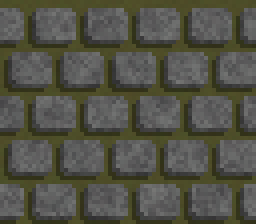

Final result


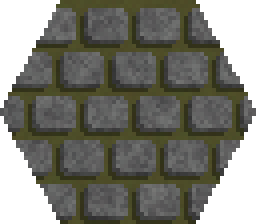

In [779]:
scale = 4
mask = TileGen.gen_hex_mask(64, 'flat')
bmask = TileGen.gen_brick_pattern_mask(mask.size, (13, 11), 2, 1)
bmaskoff = bmask.offset((-1, 1)).invert()
base = TileGen.gen_adv_tile('gravel', mask.size)
basedark = base.copy().enhance(ImageEnhance.Brightness, 0.666)
baseshade = TileOps.overlay_tiles(basedark, base, bmaskoff)
head = TileGen.gen_adv_tile('grass.dry', mask.size)
hmaskoff = bmask.offset((1, -1)).invert()
headdark = head.copy().enhance(ImageEnhance.Brightness, 0.666)
headshade = TileOps.overlay_tiles(head, headdark, hmaskoff)
brick_mortar = TileOps.overlay_tiles(baseshade, headshade, bmask)
brick_mortar_tile = brick_mortar.copy().cutout(mask)


# print("Base texture")
# base.display(scale)

# print("Base texture but darker")
# basedark.display(scale)

# print("Shaded base texture")
# baseshade.display(scale)

# print("Head texture")
# head.display(scale)

# print("Brick pattern mask")
# bmask.display(scale)

# print("Brick pattern mask offset")
# bmaskoff.display(scale)

print("Overlay result")
brick_mortar.display(scale)

# print("Hexagonal cut mask")
# mask.display(scale)

print("Final result")
brick_mortar_tile.display(scale)

Base texture


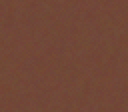

Head texture


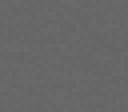

Brick pattern mask


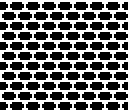

Overlay result


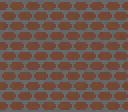

Hexagonal cut mask


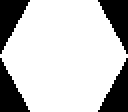

Final result


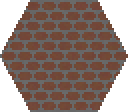

In [718]:
scale = 2
mask = TileGen.gen_hex_mask(64, 'flat')
bmask = TileGen.gen_brick_pattern_mask(mask.size, (8, 5), 1, 1)
base = TileGen.gen_adv_tile('clay', mask.size)
head = TileGen.gen_adv_tile('stone', mask.size)
brick_mortar = TileOps.overlay_tiles(base, head, bmask)
brick_mortar_tile = brick_mortar.copy().cutout(mask)


print("Base texture")
base.display(scale)

print("Head texture")
head.display(scale)

print("Brick pattern mask")
bmask.display(scale)

print("Overlay result")
brick_mortar.display(scale)

print("Hexagonal cut mask")
mask.display(scale)

print("Final result")
brick_mortar_tile.display(scale)

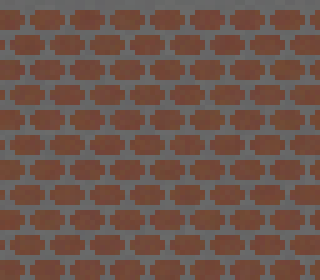

In [719]:
brick_mortar.offset((-1,-1)).display(5)

In [ ]:
mask = TileGen.gen_hex_mask(80)#, 'flat')

tile = (TileGen
    .gen_adv_tile('grass', mask.size)
    .cutout(mask)
)
tile.display(4)






In [ ]:
SCALE = 2

print("Grass")
(TileGen
    .gen_rnd_rgb((96, 96), ((48, 64), (64, 108), (24, 32)))
    .apply_filters([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.9)
).display(SCALE)

print("DryGrass")
(TileGen
    .gen_rnd_rgb((96, 96), ((80, 8), (80, 8), (24, 4)), 'avgdev')
    .apply_filters([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.66)
).display(SCALE)

print("Moss")
(TileGen
    .gen_rnd_rgb((96, 96), ((48, 4), (64, 4), (24, 4)), 'avgdev')
    #.apply_filters([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Water")
(TileGen
    .gen_rnd_rgb((96, 96), ((24, 32), (32, 48), (80, 120)))
    .apply_filters([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
).display(SCALE)

print("Dirt")
(TileGen
    .gen_rnd_rgb((96, 96), ((140, 160), (100, 120), (64, 80)))
    .apply_filters([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Mud")
(TileGen
    .gen_rnd_rgb((96, 96), ((100, 6), (72, 6), (56, 4)), 'avgdev')
    .apply_filters([ImageFilter.SMOOTH])
).display(SCALE)

print("Sand")
(TileGen
    .gen_rnd_rgb((96, 96), ((240, 255), (200, 220), (180, 192)))
    .apply_filters([ImageFilter.SMOOTH])
).display(SCALE)

print("Clay")
(TileGen
    .gen_rnd_rgb((96, 96), ((108, 120), (64, 80), (48, 64)))
    .apply_filters([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Stone")
(TileGen
    .gen_rnd_rgb((48, 48), ((100, 108), (100, 108), (100, 108)))
    .scale(2, Image.Resampling.NEAREST)
    .enhance(ImageEnhance.Color, 0.2)
).display(SCALE)

print("Gravel")
(TileGen
    .gen_rnd_rgb((48, 48), ((96, 48), (96, 48), (96, 12)), 'avgdev')
    .apply_filters([ImageFilter.SMOOTH_MORE])
    .scale(2, Image.Resampling.NEAREST)
    .enhance(ImageEnhance.Color, 0.05)
).display(SCALE)














In [ ]:
# TileGen.gen_hex_mask((24, 12), 'flat', 4).display(4)
# TileGen.gen_iso_mask(24).display(4)
(TileGen
    .gen_rnd_rgb((24, 12), ((48, 64), (64, 108), (24, 32)))
    .apply_filters([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.9)
    .cutout(TileGen.gen_iso_mask(24))
).display(4)

In [ ]:
from PIL import Image, ImageTransform

image = Image.open("test.png")
display_image(image, 8)



# Define the shear factor (e.g., 0.5 for moderate shear)
shear_x = 1.0  # x-shear
shear_y = 0.0  # no y-shear

# Construct the 6-tuple affine matrix for shearing
# Affine matrix is (a, b, c, d, e, f)
# For shear in x-direction: b = shear_x
# Transformation matrix:
# | a  b  c |
# | d  e  f |
# | 0  0  1 |

# sx=-1 -> image.size[0] + (image.size[0] * shear_x)
# sx=1  -> -(image.size[0] * shear_x)
matrix = (
    1,       shear_x, -(image.size[0] * shear_x),
    shear_y,       1, 0,
    0,             0, 1,
) 

# Create AffineTransform object
transform = ImageTransform.AffineTransform(matrix)

resize = (
    int(image.size[0] * (1 + abs(shear_x))),
    int(image.size[1] * (1 + abs(shear_y))),
)

sheared_image = image.transform(resize, transform, resample=Image.Resampling.NEAREST)

display_image(sheared_image, 8)